K-Means

In [577]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%run silhouette_plotter.py
from mpl_toolkits.mplot3d import Axes3D

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [468]:
sql = '''
SELECT *  FROM `eth-tokens.alldata.clean_avg_with_balances_tokens_1MM` LIMIT 25000
'''

df = client.query(sql).to_dataframe()

In [469]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [470]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4

In [471]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)

cl.fit(results)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

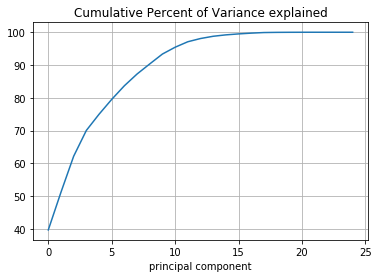

In [472]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

Text(0.5,1,'Calinski Harabaz Scores')

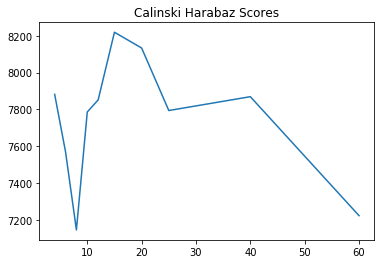

In [473]:
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [4,6,8,10,12,15,20,25, 40, 60]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

Text(0,0.5,'within cluster sum of squares')

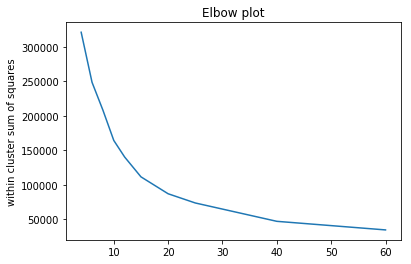

In [474]:
#elbow plot
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')

In [475]:
#optimal number of clusters is around 20
cl = KMeans(20)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [476]:
#outlier removal


def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)


In [477]:
thresholds = np.linspace(.3,3, 20)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

Text(0.5,1,'Calinski Harabaz Scores as std threshold changes')

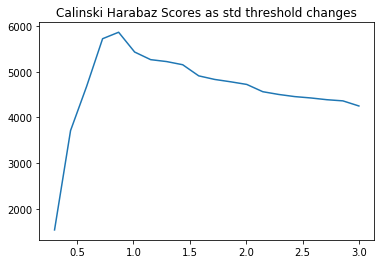

In [478]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [479]:
#empirical best threshold 1 stdev
newresults, labels = remove_outliers(results, cl,.75)

For n_clusters = 20 The average silhouette_score is : 0.24969900877037893
cluster 0 labelled
cluster 1 labelled
cluster 2 labelled
cluster 3 labelled
cluster 4 labelled
cluster 5 labelled
cluster 6 labelled
cluster 7 labelled
cluster 8 labelled
cluster 9 labelled
cluster 10 labelled
cluster 11 labelled
cluster 12 labelled
cluster 13 labelled
cluster 14 labelled
cluster 15 labelled
cluster 16 labelled
cluster 17 labelled
cluster 18 labelled
cluster 19 labelled


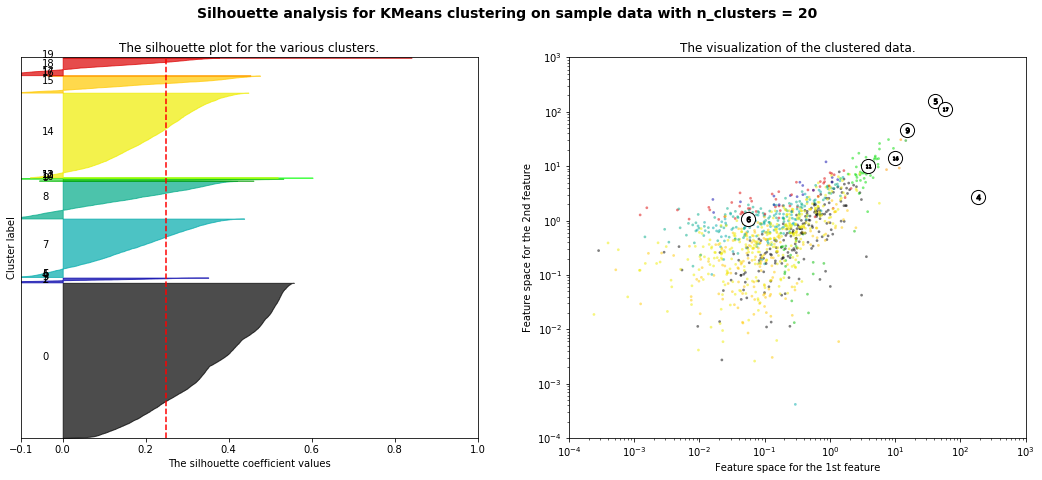

In [551]:
%run silhouette_plotter.py
X=results
range_n_clusters = [20]
if len(newresults) <20000:
    silhouette_plotter(X, range_n_clusters)

In [554]:
import time
from sklearn.manifold import TSNE
n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.030s...
[t-SNE] Computed neighbors for 25000 samples in 6.220s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for sa

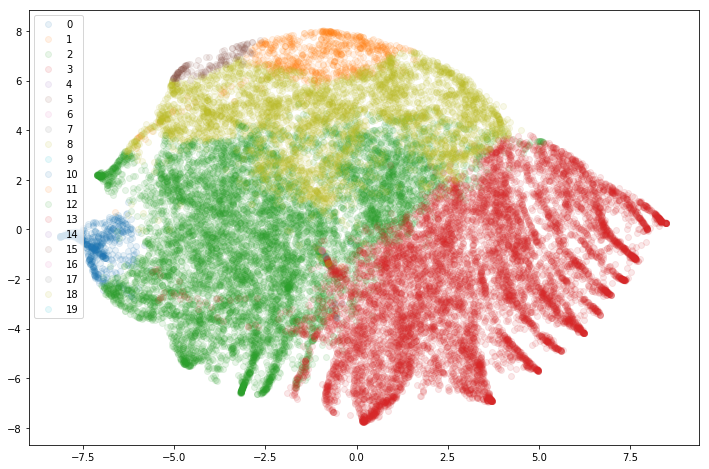

In [575]:
plt.figure(figsize=(12,8))
for c in np.unique(cl.labels_):
    mask = cl.labels_==c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], alpha=.1,label=c)
plt.legend()


In [576]:
#3d
import time
from sklearn.manifold import TSNE
n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.025s...
[t-SNE] Computed neighbors for 25000 samples in 6.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for sa

In [587]:
%matplotlib widget

FigureCanvasNbAgg()

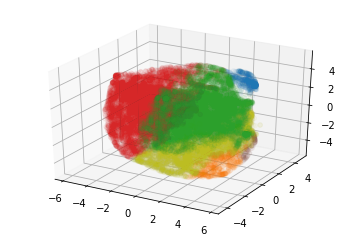

In [591]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c in np.unique(cl.labels_):
    mask = cl.labels_==c
    ax.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], tsne_results[mask][:,2], alpha=.05,label=c)

FigureCanvasNbAgg()

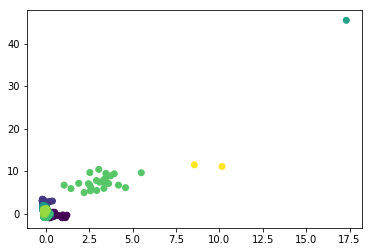

In [590]:

plt.scatter(newresults[:,0],newresults[:,1],c=labels)
# plt.xlim(0,10)
# plt.ylim(-10,10)

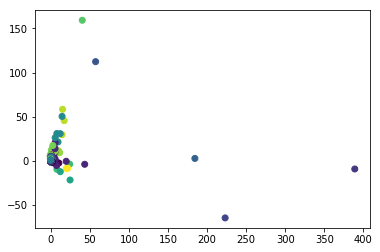

In [490]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)

In [483]:
#recluster after changes
cl = KMeans(20).fit(results)
newcl = KMeans(20).fit(newresults)

In [491]:
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [485]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

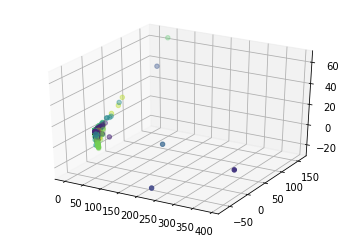

In [492]:

# plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-15,10)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)

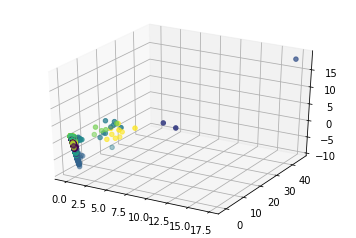

In [493]:
# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)
# ax.set_xlim3d(-1,1)
# ax.set_ylim3d(-3,3)
# ax.view_init(elev=-0, azim=90)
# for ii in range(10,360,10):
#     ax.view_init(elev=10, azim=ii)
#     fig.savefig("movie/movie{}.png".format(ii))

In [502]:
c = cl.cluster_centers_
#transform back to real numbers
centroids = scale.inverse_transform(pca.inverse_transform(c))
df_summary = pd.DataFrame(centroids, columns = data.columns)

In [503]:
cluster_sizes = pd.Series(cl.labels_).value_counts()
df_summary['cluster_size'] = cluster_sizes


In [504]:
df_summary.sort_values('cluster_size', ascending=False, axis=0, inplace=True)
df_summary

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster_size
13,35.087927,55.172389,2.423319e+02,1.002269e+01,1.192876e+05,5.469565e+03,2.534288e+02,9.112480,1.261087e+05,4.782963e+03,...,1.534321e+04,1.145186e-01,8.747122e+00,7.541997e+05,8.997749e+05,9.976126e+05,1.083616e+06,5.913398,11.565747,9814
2,56.962882,85.331161,1.192718e+03,2.567861e+01,2.768562e+05,7.019731e+03,1.020270e+03,24.542429,2.781869e+05,5.841882e+03,...,1.653617e+04,1.749049e-01,1.589299e+01,8.919124e+05,1.383255e+06,1.180701e+06,1.667571e+06,16.024443,39.553682,5524
12,13.612591,7.670324,7.057346e+01,7.178247e+00,3.598267e+04,3.648105e+03,8.545513e+01,10.918166,4.153511e+04,5.301470e+03,...,3.290693e+03,1.018809e-01,1.582393e+01,3.075594e+06,4.003794e+06,1.842975e+06,2.357770e+06,9.722309,12.373418,3832
18,5.579564,25.539028,6.792382e+01,1.103960e+01,2.765931e+04,4.476797e+03,1.132366e+02,10.871002,3.890426e+04,3.427968e+03,...,2.955208e+03,2.881072e-02,1.612697e+01,1.720319e+06,2.253103e+06,4.688038e+06,5.512598e+06,8.550084,21.607782,2984
8,7.658500,5.178174,1.220931e+02,1.029355e+01,3.351990e+04,3.433474e+03,1.557034e+02,25.200814,3.497814e+04,7.087276e+03,...,2.253785e+03,4.432071e-01,1.030290e+01,6.660486e+06,8.570513e+06,3.345038e+06,4.197364e+06,10.161099,37.265538,1346
1,4.043185,16.267206,1.396159e+02,2.602175e+01,4.041857e+04,8.567543e+03,2.240645e+02,30.187504,4.123252e+04,6.641668e+03,...,2.488682e+03,5.802969e-02,1.695007e+00,3.728955e+06,5.126756e+06,9.497171e+06,1.175430e+07,9.641026,71.268747,739
0,293.762887,95.022337,1.396703e+03,7.197116e+00,7.052398e+05,3.588937e+03,1.480603e+03,8.048220,7.380202e+05,3.900658e+03,...,5.825973e+04,2.491409e-01,3.587801e+01,1.508593e+06,1.825338e+06,1.086310e+06,1.507230e+06,98.204467,13.978186,582
15,7.180000,3.773333,1.643910e+03,9.045192e+01,5.840973e+05,3.249364e+04,6.525650e+02,128.832404,5.080255e+04,1.456944e+04,...,2.393695e+03,6.220000e+00,1.546667e+00,1.551836e+07,1.945572e+07,6.887398e+06,9.089421e+06,9.073333,45.561475,150
16,38.285714,32.000000,9.458907e+03,5.425467e+02,4.270029e+06,2.156948e+05,2.403150e+04,1966.940966,5.530901e+06,3.653071e+05,...,7.699439e+05,3.903544e-13,2.010836e-12,1.935506e+06,3.538466e+06,2.776885e+06,4.778693e+06,22.571429,29623.459016,7
9,12.428571,6.428571,5.522496e+04,4.541840e+03,9.778801e+06,8.053304e+05,6.833652e+04,10726.372607,7.686917e+06,1.092815e+06,...,5.752928e+05,1.516343e-12,3.832668e-11,1.602107e+06,2.446663e+06,1.515032e+06,2.712068e+06,17.000000,8040.208245,7


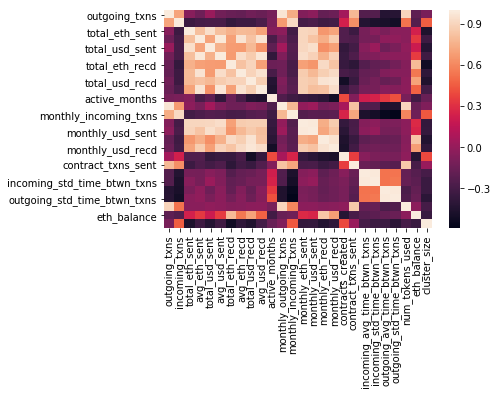

In [498]:
import seaborn as sns
sns.heatmap(df_summary.corr())

In [499]:
arr = df_summary.values

In [500]:
arr.shape

(20, 26)

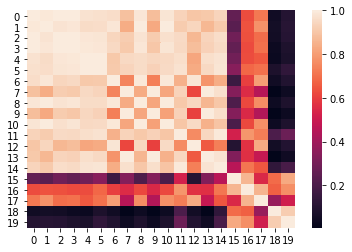

In [501]:
sns.heatmap(np.corrcoef(arr, rowvar=True))

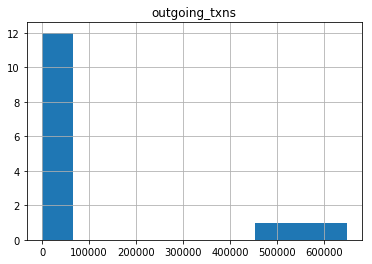

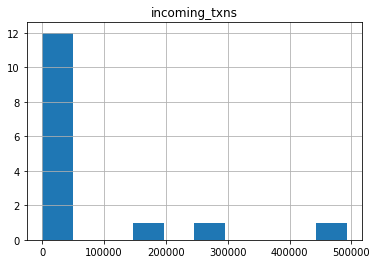

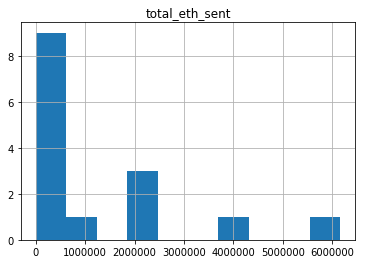

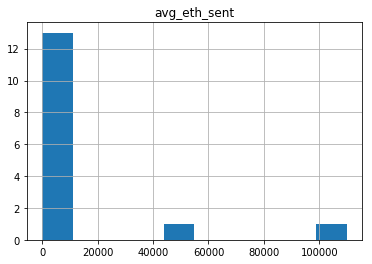

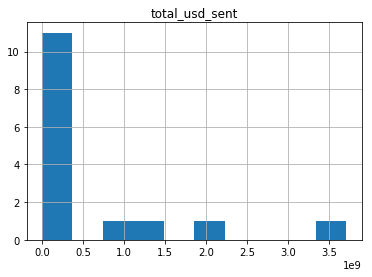

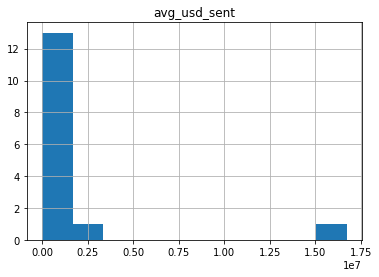

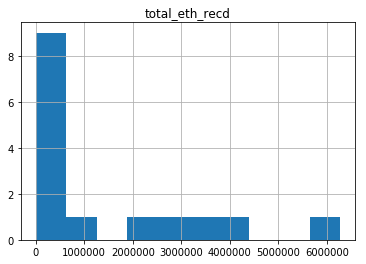

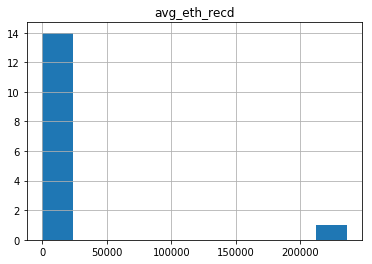

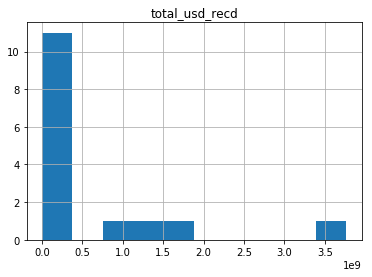

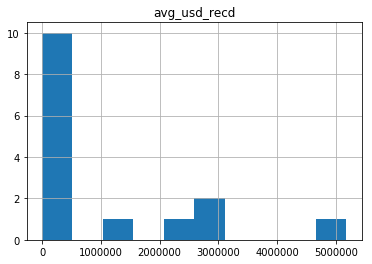

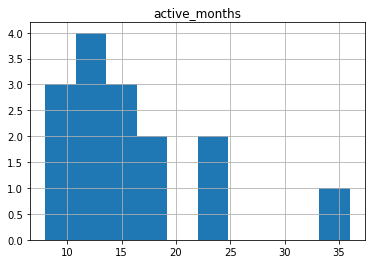

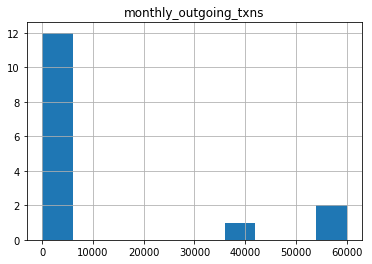

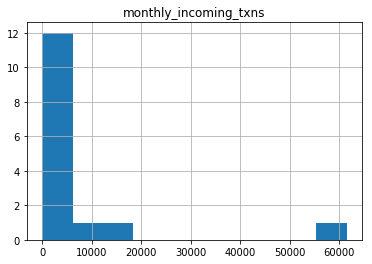

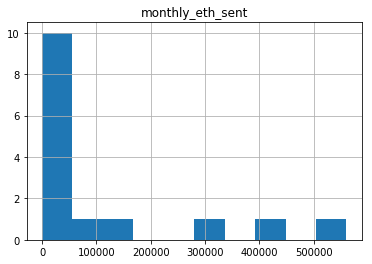

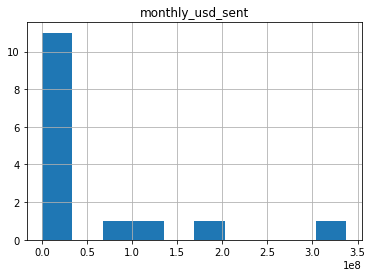

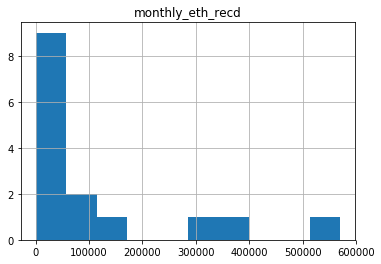

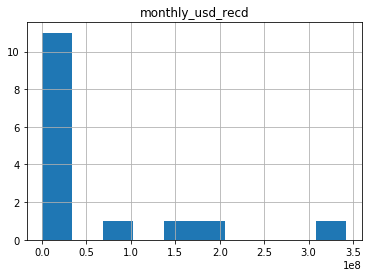

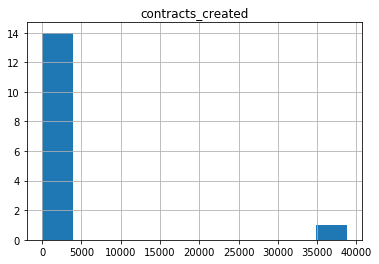

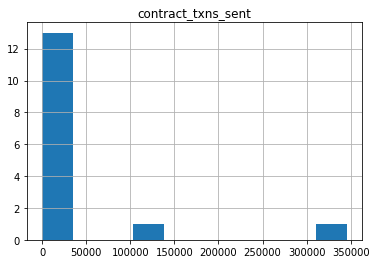

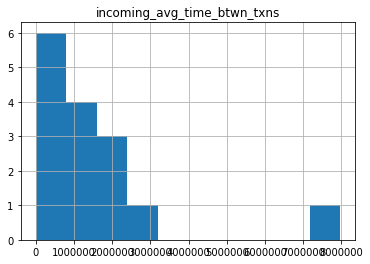

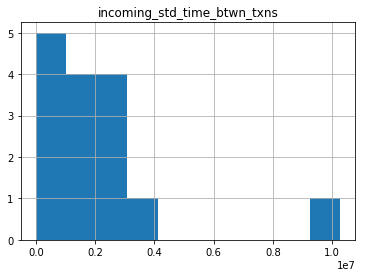

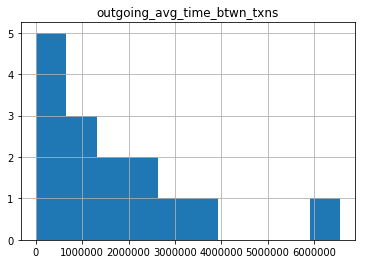

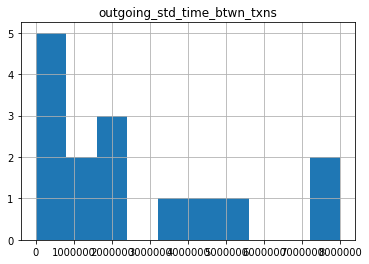

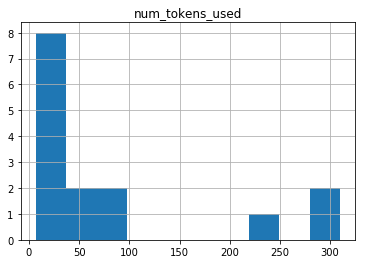

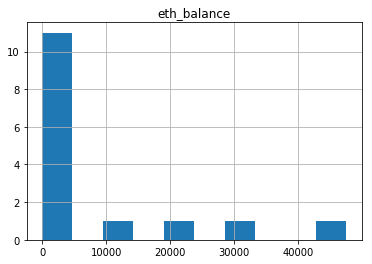

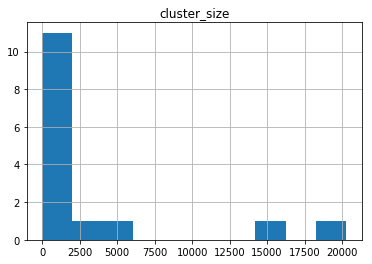

In [425]:
for col in df_summary.columns:
    df_summary[col].hist()
    plt.title(col)
    plt.show()

In [426]:
p = PCA(n_components=3)

In [427]:
vectors = p.fit_transform(arr[:8,:])

In [428]:

xs = vectors[:,0]
ys = vectors[:,1]
zs = vectors[:,2]

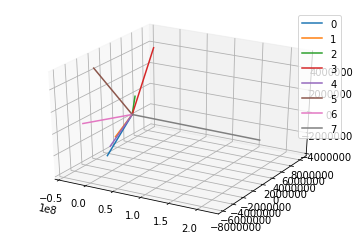

In [429]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
    ax.plot([0,x], [0,y],[0,z], label=i)
plt.legend()

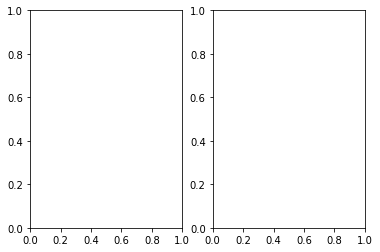

In [506]:
fig, (ax1, ax2) = plt.subplots(1, 2)


In [508]:
ax1.loglog()

[]